In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect("C:\\glowpickDB.db")
df = pd.read_sql_query("SELECT * FROM innisfree", con)
df2 = pd.read_sql("SELECT age,skin_type, gender, product_id, user_id, rating,  review_count, name FROM innisfree", con)
#df2.head(20)
df2.shape

(149711, 8)

In [3]:
df2['user_id']=pd.to_numeric(df2['user_id'])
df2['product_id']=pd.to_numeric(df2['product_id'])
df2['rating']=pd.to_numeric(df2['rating'])

In [4]:
#한 user의 리뷰 개수 15개 이상, product별 리뷰 개수 20개 이상인 것만
users = list(df2['user_id'].value_counts()[lambda x:x>15].index)
products = list(df2['product_id'].value_counts()[lambda x:x>20].index)
new_df = df2[(df2['user_id'].isin(users)) & df2['product_id'].isin(products)]
print(new_df.shape) #데이터 수 많이 줄임

(29856, 8)


In [5]:
new_df.head() #앞에서의 스터디 내용 외에, 여기서 'age','skin_type','gender'변수도 'rating'에 영향을 미치는지를 알아보자.

,age,skin_type,gender,product_id,user_id,rating,review_count,name
31,31.0,건성,f,142,715142,3,284,유채꿀 립밤 스틱
46,21.0,민감성,f,142,1045856,5,100,유채꿀 립밤 스틱
47,31.0,건성,m,142,1137569,4,23,유채꿀 립밤 스틱
54,19.0,복합성,f,142,730493,2,185,유채꿀 립밤 스틱
71,21.0,복합성,f,142,709291,3,219,유채꿀 립밤 스틱


## age변수에 대해: age가 rating에 유의미한 변수인가?

Text(0, 0.5, 'age')

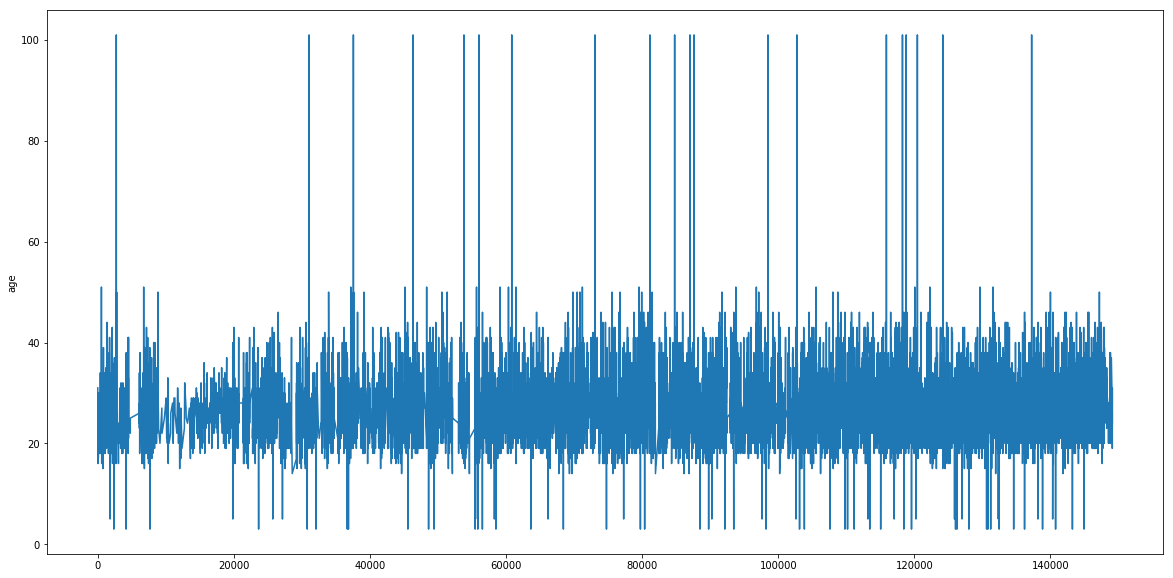

In [6]:
plt.figure(figsize=(20,10))
plt.plot(new_df['age'])
plt.ylabel("age") #20~40대 구간에 엄청 분포

{'whiskers': [<matplotlib.lines.Line2D at 0x2aab48d7cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x2aab5a953c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aab48d7908>],
 'medians': [<matplotlib.lines.Line2D at 0x2aab5a95a58>],
 'fliers': [<matplotlib.lines.Line2D at 0x2aab5a95da0>],
 'means': []}

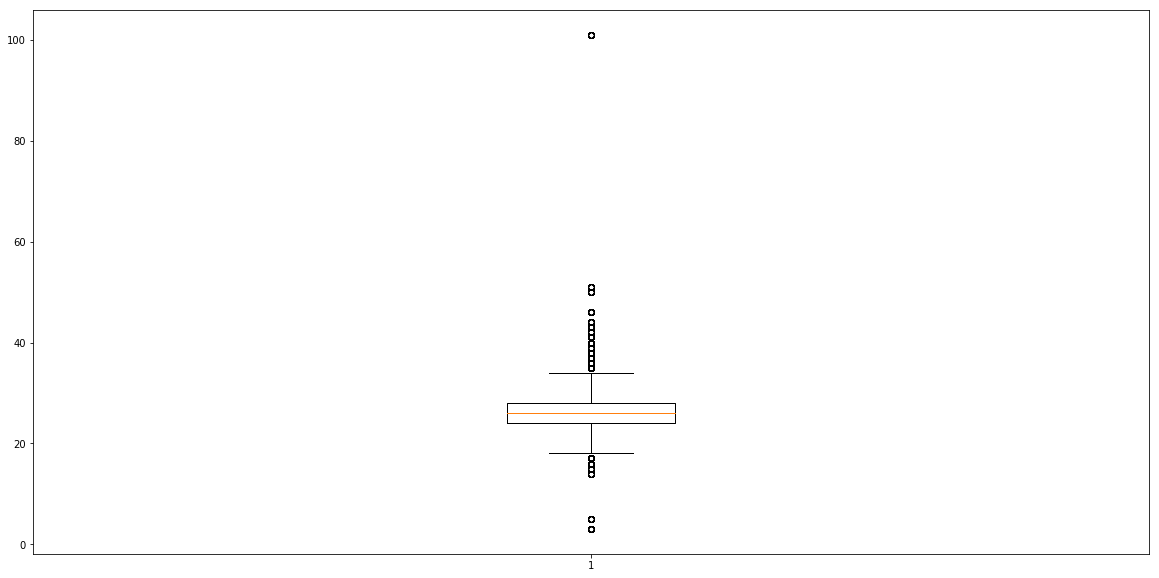

In [7]:
plt.figure(figsize=(20,10))
plt.boxplot(new_df['age']) #20~30대 구간에 대부분 위치, 다른 구간은 이상치
#너무 한 구간에 몰려 있어서 유효한 데이터로 보기는 어려움. #하지만 사후처리를 위해 뒤의 내용 진행

In [8]:
newdf2=new_df[new_df['age']<60] #age가 60보다 작은 것만 대상

In [9]:
#범주화
stype=[]
for i in newdf2['age']:
    if (i<20):
        stype.append(1)
    elif ((i>= 20) & (i<25)):
        stype.append(2)
    elif ((i>=25) & (i<30)):
        stype.append(3)
    elif ((i>=30) & (i<35)):
        stype.append(4)
    else :
        stype.append(5)
newdf2['age_group']=stype

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
newdf2.head()

,age,skin_type,gender,product_id,user_id,rating,review_count,name,age_group
31,31.0,건성,f,142,715142,3,284,유채꿀 립밤 스틱,4
46,21.0,민감성,f,142,1045856,5,100,유채꿀 립밤 스틱,2
47,31.0,건성,m,142,1137569,4,23,유채꿀 립밤 스틱,4
54,19.0,복합성,f,142,730493,2,185,유채꿀 립밤 스틱,1
71,21.0,복합성,f,142,709291,3,219,유채꿀 립밤 스틱,2


In [11]:
ndf2_g=newdf2.groupby(by=['product_id','age_group']).mean()
ndf2_g.reset_index(level=['product_id','age_group'], inplace=True)

In [12]:
ndf2_g.head(10)

,product_id,age_group,age,user_id,rating,review_count
0,142,1,17.812500,597069.875000,3.531250,127.812500
1,142,2,22.363636,396161.154545,3.727273,153.863636
2,142,3,26.462025,309242.639241,3.651899,186.575949
3,142,4,31.600000,427202.400000,3.775000,240.650000
4,142,5,40.100000,289152.200000,4.100000,387.100000
5,144,1,19.000000,27509.000000,2.000000,301.500000
6,144,2,22.200000,41031.600000,2.800000,426.000000
7,144,3,27.000000,330573.642857,2.857143,225.571429
8,144,4,31.000000,220003.000000,2.666667,138.666667
9,498,1,17.473684,565316.947368,3.368421,159.526316


In [13]:
rate_avg=pd.DataFrame(new_df.groupby(by=['product_id']).mean()['rating']) # 각 아이템별(피부타입 상관 X) 평균을 구함
rate_avg.reset_index(level=['product_id'], inplace=True) #index되어버린 product id 다시 컬럼으로 가져옴

In [14]:
result2 = pd.merge(ndf2_g, rate_avg, on='product_id') # 각 아이템별 평균 컬럼을 merge 
result2.head(20) #rating_x는 각 나이별로 평균 평점이고 , rating_y는 나이고려x 평균 평점임

,product_id,age_group,age,user_id,rating_x,review_count,rating_y
0,142,1,17.812500,597069.875000,3.531250,127.812500,3.691429
1,142,2,22.363636,396161.154545,3.727273,153.863636,3.691429
2,142,3,26.462025,309242.639241,3.651899,186.575949,3.691429
3,142,4,31.600000,427202.400000,3.775000,240.650000,3.691429
4,142,5,40.100000,289152.200000,4.100000,387.100000,3.691429
5,144,1,19.000000,27509.000000,2.000000,301.500000,2.750000
6,144,2,22.200000,41031.600000,2.800000,426.000000,2.750000
7,144,3,27.000000,330573.642857,2.857143,225.571429,2.750000
8,144,4,31.000000,220003.000000,2.666667,138.666667,2.750000
9,498,1,17.473684,565316.947368,3.368421,159.526316,3.385042


In [15]:
result2['dominus']=((result2['rating_x']-result2['rating_y'])<=-1) #rating_x(각 나이별 평균)-rating_y(아이템별 평균) 이 -1보다 작으면 dominus 열에 TRUE
age_result=result2[result2['dominus']]
age_result #평균과 -1보다 더 차이가 나는 데이터는 99개로 줄여졌다. #여기서 나온 것은 후처리 작업이 필요한 것.(추천 시 이 age group엔 이 상품을 추천해주지 않도록 설정(후에홈페이지)..)

,product_id,age_group,age,user_id,rating_x,review_count,rating_y,dominus
16,501,4,32.000000,8.485200e+04,1.000000,375.000000,2.900000,True
26,855,1,19.000000,3.982480e+05,1.500000,234.000000,3.352381,True
39,857,5,41.000000,2.498130e+05,1.000000,274.000000,2.352941,True
70,1003,5,43.000000,8.330400e+04,2.000000,1659.000000,3.250000,True
105,1498,2,22.000000,3.670300e+04,2.000000,140.000000,3.833333,True
157,3148,5,35.000000,3.550650e+05,2.000000,112.000000,3.476636,True
181,6843,5,39.000000,2.463475e+05,2.000000,705.000000,3.489362,True
186,6844,5,46.000000,8.469700e+04,2.000000,318.000000,3.157895,True
216,6851,5,35.000000,3.550650e+05,2.000000,112.000000,3.397849,True
229,6857,1,3.000000,6.760400e+04,2.000000,29.000000,3.719512,True


## gender변수에 대해: gender가 rating에 유의미한 변수인가?

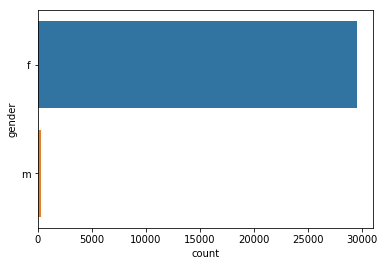

In [16]:
import seaborn as sns
sns.countplot(y='gender',data=new_df)

In [17]:
ndf3_g=new_df.groupby(by=['product_id','gender']).mean()
ndf3_g.reset_index(level=['product_id','gender'], inplace=True)

In [18]:
ndf3_g.head(20) #딱 보기에도 f에 치우쳐져 있음

,product_id,gender,age,user_id,rating,review_count
0,142,f,25.342029,371911.802899,3.678261,184.359420
1,142,m,26.600000,642869.200000,4.600000,77.400000
2,144,f,25.833333,231175.666667,2.750000,262.791667
3,498,f,26.024931,350017.232687,3.385042,217.736842
4,501,f,28.000000,158531.300000,2.900000,247.500000
5,502,f,25.891892,266782.054054,3.351351,231.459459
6,503,f,26.636364,96157.181818,2.727273,369.727273
7,855,f,27.504762,257783.609524,3.352381,250.123810
8,856,f,28.000000,190055.545455,3.272727,384.000000
9,857,f,27.176471,175348.352941,2.352941,307.941176


In [19]:
ndf3_g.shape

(798, 6)

In [20]:
many=list(ndf3_g['product_id'].value_counts()[lambda x: x>1].index)
new_3=ndf3_g[ndf3_g['product_id'].isin(many)]

In [21]:
new_3.head() #그냥 그룹바이로 묶으면 gender가 f만인 것도 있어서 f,m둘다있는걸로 

,product_id,gender,age,user_id,rating,review_count
0,142,f,25.342029,371911.802899,3.678261,184.359420
1,142,m,26.600000,642869.200000,4.600000,77.400000
12,861,f,25.548230,344251.946276,4.217338,198.935287
13,861,m,23.666667,518943.000000,3.666667,97.333333
16,864,f,26.090909,141421.651515,2.924242,229.727273


In [22]:
new_3.shape #그런데 f,m 둘 다 있는 것으로 고르니까 데이터의 수가 확 줄었다. 즉 대부분의 데이터가 여성에게만 치우쳐져 있음
#역시 한쪽으로만 쏠려 있어서 유효한 데이터로 보기가 어려움. 사후처리를 위해 다음 진행..

(346, 6)

In [23]:
rate_avg=pd.DataFrame(new_3.groupby(by=['product_id']).mean()['rating']) # 각 아이템별(성별 상관 X) 평균을 구함
rate_avg.reset_index(level=['product_id'], inplace=True) #index되어버린 product id 다시 컬럼으로 가져옴

rate_avg.head()

,product_id,rating
0,142,4.139130
1,861,3.942002
2,864,2.462121
3,1032,3.300319
4,1066,3.711391


In [24]:
result = pd.merge(new_3, rate_avg, on='product_id') # 각 아이템별 평균 컬럼을 merge 
result.head(20) #rating_x는 각 성별로 평균 평점이고 , rating_y는 모든 성별의 평균 평점임.

,product_id,gender,age,user_id,rating_x,review_count,rating_y
0,142,f,25.342029,371911.802899,3.678261,184.359420,4.139130
1,142,m,26.600000,642869.200000,4.600000,77.400000,4.139130
2,861,f,25.548230,344251.946276,4.217338,198.935287,3.942002
3,861,m,23.666667,518943.000000,3.666667,97.333333,3.942002
4,864,f,26.090909,141421.651515,2.924242,229.727273,2.462121
5,864,m,21.000000,512353.000000,2.000000,85.000000,2.462121
6,1032,f,26.974441,283837.428115,3.600639,215.897764,3.300319
7,1032,m,22.500000,327269.500000,3.000000,60.500000,3.300319
8,1066,f,26.715596,335954.415902,3.672783,210.776758,3.711391
9,1066,m,28.000000,318810.000000,3.750000,91.250000,3.711391


In [25]:
result['dominus']=((result['rating_x']-result['rating_y'])<=-1) #rating_x(각 성별 평균)-rating_y(아이템별 평균) 이 -1보다 작으면 dominus 열에 TRUE
gender_result=result[result['dominus']]
gender_result #평균과 -1보다 더 차이가 나는 데이터는 6개로 줄여졌다.

,product_id,gender,age,user_id,rating_x,review_count,rating_y,dominus
101,6964,m,21.000000,512353.000000,2.000000,85.000000,3.120536,True
146,7140,f,27.823529,170636.058824,2.529412,371.588235,3.764706,True
151,7198,m,28.000000,61369.000000,2.000000,38.000000,3.400000,True
153,7208,m,28.000000,61369.000000,2.000000,38.000000,3.031250,True
293,76446,m,19.000000,667276.000000,1.000000,65.000000,2.038462,True
299,77955,m,19.000000,667276.000000,1.000000,65.000000,2.846154,True


## skin_type변수에 대해: skin_type이 rating에 유의미한 변수인가?

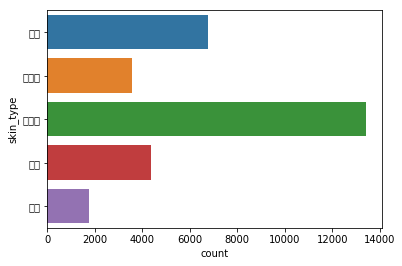

In [36]:
sns.countplot(y='skin_type',data=new_df) #분포는 어느 정도 의미 있다고 봄

In [26]:
new_df_group=new_df.groupby(by=['product_id','skin_type']).mean() #각 피부타입별 평균 구한 df
new_df_group.reset_index(level=['product_id','skin_type'], inplace=True) # product id, skin type이 index로 되는거 다시 column 변수로

In [27]:
new_df_group.head()

,product_id,skin_type,age,user_id,rating,review_count
0,142,건성,26.262500,350968.912500,3.725000,171.812500
1,142,민감성,25.191489,466352.148936,3.872340,238.808511
2,142,복합성,25.284810,373621.702532,3.677215,177.962025
3,142,중성,26.428571,372651.428571,3.785714,210.571429
4,142,지성,24.039216,338794.215686,3.490196,156.000000


In [39]:
#skin_type이 유효한 변수임을 보이기: index 순위 이용
dry=pd.DataFrame(new_df_group[new_df_group['skin_type']=='건성'])
med=pd.DataFrame(new_df_group[new_df_group['skin_type']=='중성'])
oil=pd.DataFrame(new_df_group[new_df_group['skin_type']=='지성'])
sens=pd.DataFrame(new_df_group[new_df_group['skin_type']=='민감성'])
combine=pd.DataFrame(new_df_group[new_df_group['skin_type']=='복합성'])

dry = dry.sort_values(["rating"], ascending=[False]) #건성에 대해서만, rating이 높은 순서대로
dry.head()

,product_id,skin_type,age,user_id,rating,review_count
2208,77955,건성,24.5,296666.0,5.0,301.5
1940,54529,건성,33.0,154269.0,5.0,188.0
2616,92483,건성,24.5,704576.0,5.0,344.5
1334,21235,건성,28.0,225507.0,5.0,149.0
2671,93404,건성,19.0,635906.0,5.0,328.0


In [31]:
dry_list = list(dry['product_id'])
med_list = list(med['product_id'])
oil_list = list(oil['product_id'])
sens_list = list(sens['product_id'])
combine_list = list(combine['product_id'])

In [32]:
dry_list.append("건성")
med_list.append("중성")
oil_list.append("지성")
sens_list.append("민감성")
combine_list.append("복합성")

In [33]:
def compare_type_rank(list1, list2, list3, list4, list5):
    skin_type_1 = list1[-1]
    skin_type_2 = list2[-1]
    skin_type_3 = list3[-1]
    skin_type_4 = list4[-1]
    skin_type_5 = list5[-1]
    compare_dict = {}
    list1_ranks = [i for i in range(1, 11)]
    list2_ranks = []
    list3_ranks = []
    list4_ranks = []
    list5_ranks = []
    for product_id in list1[:10]:
        list
        if product_id in list2:
            list2_ranks.append(list2.index(product_id) + 1)
        else:
            list2_ranks.append("--")
        if product_id in list3:
            list3_ranks.append(list3.index(product_id) + 1)
        else:
            list3_ranks.append("--")            
        if product_id in list4:
            list4_ranks.append(list4.index(product_id) + 1)
        else:
            list4_ranks.append("--")
        if product_id in list5:
            list5_ranks.append(list5.index(product_id) + 1)
        else:
            list5_ranks.append("--")            
    compare_dict[skin_type_1] = list1_ranks
    compare_dict[skin_type_2] = list2_ranks
    compare_dict[skin_type_3] = list3_ranks
    compare_dict[skin_type_4] = list4_ranks
    compare_dict[skin_type_5] = list5_ranks
    return compare_dict


In [34]:
dry_df = pd.DataFrame(data = compare_type_rank(dry_list, med_list, oil_list, sens_list, combine_list), index=[i for i in range(1,11)])
med_df = pd.DataFrame(compare_type_rank(med_list, dry_list, oil_list, sens_list, combine_list), index=[i for i in range(1,11)])
oil_df = pd.DataFrame(compare_type_rank(oil_list, med_list, dry_list, sens_list, combine_list), index=[i for i in range(1,11)])
sens_df = pd.DataFrame(compare_type_rank(sens_list, oil_list, med_list, dry_list, combine_list), index=[i for i in range(1,11)])
combine_df = pd.DataFrame(compare_type_rank(combine_list, sens_list, oil_list, med_list, dry_list), index=[i for i in range(1,11)])

In [35]:
dry_df #건성에서 rating 1위로 나온 제품은 중성에선 찾아볼 수 없고, 지성에선 450위, 민감성은 437위, 복합성은 488위이다.
#피부타입에 따라 제품의 선호도가 달라짐을 알 수 있다.

,건성,중성,지성,민감성,복합성
1,1,--,450,437,488
2,2,--,393,--,427
3,3,--,532,511,581
4,4,--,271,267,294
5,5,440,--,521,595
6,6,--,328,326,356
7,7,--,--,212,234
8,8,403,499,--,--
9,9,400,--,480,542
10,10,--,212,--,229


In [37]:
rate_avg=pd.DataFrame(new_df.groupby(by=['product_id']).mean()['rating']) # 각 아이템별(피부타입 상관 X) 평균을 구함


rate_avg.reset_index(level=['product_id'], inplace=True) #index되어버린 product id 다시 컬럼으로 가져옴

rate_avg

,product_id,rating
0,142,3.691429
1,144,2.750000
2,498,3.385042
3,501,2.900000
4,502,3.351351
5,503,2.727273
6,855,3.352381
7,856,3.272727
8,857,2.352941
9,859,3.181818


In [38]:
result = pd.merge(new_df_group, rate_avg, on='product_id') # 각 아이템별 평균 컬럼을 merge 
result.head(20) #rating_x는 각 피부타입별로 평균 평점이고 , rating_y는 모든 피부타입의 평균 평점임.

,product_id,skin_type,age,user_id,rating_x,review_count,rating_y
0,142,건성,26.262500,350968.912500,3.725000,171.812500,3.691429
1,142,민감성,25.191489,466352.148936,3.872340,238.808511,3.691429
2,142,복합성,25.284810,373621.702532,3.677215,177.962025,3.691429
3,142,중성,26.428571,372651.428571,3.785714,210.571429,3.691429
4,142,지성,24.039216,338794.215686,3.490196,156.000000,3.691429
5,144,건성,26.857143,210474.428571,2.571429,313.428571,2.750000
6,144,민감성,25.500000,260088.000000,3.000000,293.000000,2.750000
7,144,복합성,25.666667,161283.777778,2.777778,252.333333,2.750000
8,144,중성,27.000000,428873.000000,4.000000,109.000000,2.750000
9,144,지성,24.600000,334858.400000,2.600000,229.400000,2.750000
